In [34]:
#Import All the Required Libraries..
import numpy as np
import pandas as pd
import re
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors

0it [00:00, ?it/s]


In [36]:
#import test and train data into dataframe..
os.getcwd()
os.chdir('C:/Users/anike/Downloads/hack_datasets/Datasets/Problem 4')
train_data = pd.read_json('train_data.json',orient='index')
test_data = pd.read_json('test_data.json',orient='index')

In [37]:
#set index
train_data.reset_index(level = 0, inplace = True)
train_data.rename(columns={'index':'ID'}, inplace=True)

test_data.reset_index(level = 0, inplace = True)
test_data.rename(columns={'index':'ID'}, inplace=True)

In [38]:
#check data
print ('Train data Number of rows {} rows and {} columns'.format(train_data.shape[0],train_data.shape[1]))
print ('test_data data Number of rows {} rows and {} columns'.format(test_data.shape[0],test_data.shape[1]))

Train data Number of rows 200000 rows and 7 columns
test_data data Number of rows 100000 rows and 6 columns


In [39]:
#Encode Target Variable
train_data = train_data.replace({'segment':{'pos':1,'neg':0}})


In [40]:
test_data = test_data.replace({'segment':{'pos':1,'neg':0}})

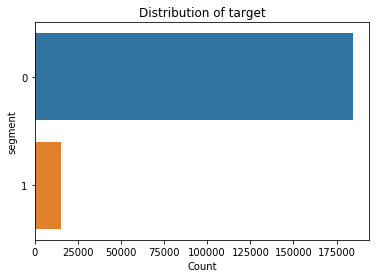

In [41]:
# Plotting distribution of Segments:
sns.countplot(y='segment', data=train_data)
plt.ylabel('segment')
plt.xlabel('Count')
plt.title('Distribution of target')
plt.show()

In [42]:
#check target variable count
train_data['segment'].value_counts()/train_data.shape[0]

0    0.923725
1    0.076275
Name: segment, dtype: float64

In [43]:
# Creating separate columns for genres
genre_data = [[str("genre_" + i) for i in re.sub(pattern='\:\d+',repl='',string=x).split(",")] for x in train_data['genres']]
genre_data = frozenset.union(*pd.Series(genre_data).apply(frozenset))

In [44]:
cities_data = [[str("cities_" + i) for i in re.sub(pattern='\:\d+', repl='', string = x).split(',')] for x in train_data['cities']]
cities_data = frozenset.union(*pd.Series(cities_data).apply(frozenset))

In [45]:
dow_data = [[str("dow_" + i) for i in re.sub(pattern='\:\d+', repl='', string = x).split(',')] for x in train_data['dow']]
dow_data = frozenset.union(*pd.Series(dow_data).apply(frozenset))

In [46]:
tod_data = [[str("tod_" + i) for i in re.sub(pattern='\:\d+', repl='', string = x).split(',')] for x in train_data['tod']]
tod_data = frozenset.union(*pd.Series(tod_data).apply(frozenset))

In [47]:
def get_genre_freq(row):
        
    genre_dict = {}
    for genre in row.genres.split(","):
        genre_name, genre_wt = genre.split(":")
        genre_dict[str("genre_" + genre_name)] = int(genre_wt)
    
    genre_freq = {}
    for i in genre_data:
        if i in genre_dict:
            genre_freq[i] = genre_dict[i] 
        else:
            genre_freq[i] = 0            

    return pd.Series(genre_freq)

In [48]:
genre_feats = train_data.progress_apply(get_genre_freq, axis = 1)

200001it [03:05, 1075.44it/s]


In [49]:
def get_dow_freq(row):
    
    dow_dict = {}
    for dow in row.dow.split(","):
        dow_name, dow_wt = dow.split(":")
        dow_dict[str("dow_" + dow_name)] = int(dow_wt)
    
    dow_freq = {}
    for i in dow_data:
        if i in dow_dict:
            dow_freq[i] = dow_dict[i] 
        else:
            dow_freq[i] = 0            

    return pd.Series(dow_freq)

def get_tod_freq(row):
    
    tod_dict = {}
    for tod in row.tod.split(","):
        tod_name, tod_wt = tod.split(":")
        tod_dict[str("tod_" + tod_name)] = int(tod_wt)
    
    tod_freq = {}
    for i in tod_data:
        if i in tod_dict:
            tod_freq[i] = tod_dict[i] 
        else:
            tod_freq[i] = 0            

    return pd.Series(tod_freq)

In [50]:
dow_feats = train_data.progress_apply(get_dow_freq, axis = 1)
tod_feats = train_data.progress_apply(get_tod_freq, axis = 1)

100%|██████████| 200000/200000 [01:16<00:00, 2623.47it/s]


In [51]:
train_data = pd.concat([train_data, genre_feats], axis = 1)
train_data = pd.concat([train_data, dow_feats], axis = 1)
train_data = pd.concat([train_data, tod_feats], axis = 1)

In [52]:
genre_feats = test_data.progress_apply(get_genre_freq, axis = 1)
dow_feats = test_data.progress_apply(get_dow_freq, axis = 1)
tod_feats = test_data.progress_apply(get_tod_freq, axis = 1)

test_data = pd.concat([test_data, genre_feats], axis = 1)
test_data = pd.concat([test_data, dow_feats], axis = 1)
test_data = pd.concat([test_data, tod_feats], axis = 1)

100%|██████████| 100000/100000 [00:36<00:00, 2764.66it/s]


In [53]:
metro_cities = ['mumbai','delhi','kolkata','chennai','bengaluru','hyderabad','ahmadabad','pune','surat','jaipur','kanpur','lucknow','nagpur','ghaziabad','indore','coimbatore','kochi','patna','kozhikode','bhopal','thrissur','vadodara','agra','malappuram','thiruvananthapuram','kannur','ludhiana','nashik','vijayawada','madurai','varanasi','meerut','faridabad','rajkot','jamshedpur','srinagar','jabalpur','asansol','vasai virar city','allahabad','dhanbad','aurangabad','amritsar','jodhpur','ranchi','raipur','kollam','gwalior','durg-bhilainagar','chandigarh','tiruchirappalli','kota']
cities_metro = ['metro','non_metro']
def get_Metro_freq(row):
    cities_dict = {}
    for city in row.cities.split(","):
        city_name, city_wt = city.split(":")
        if city_name.lower() in metro_cities:
            cities_dict[str("metro")] = int(city_wt)
        else:
            cities_dict[str("non_metro")] = int(city_wt)   
    
    metro_freq = {}
    for x in cities_metro:
        if x in cities_dict:
            metro_freq[x] = cities_dict[x]
        else:
            metro_freq[x] = 0            

    return pd.Series(metro_freq)

In [54]:
metro_feats = train_data.progress_apply(get_Metro_freq, axis = 1)

100%|██████████| 200000/200000 [01:09<00:00, 2859.02it/s]


In [55]:
train_data = pd.concat([train_data, metro_feats], axis = 1)
metro_feats

,metro,non_metro
0,64,0
1,26989,56666
2,0,29400
3,0,4005
4,0,2864
5,0,5
6,13142,3885
7,77,373
8,19504,1124
9,0,104


In [56]:
metro_feats = test_data.progress_apply(get_Metro_freq, axis = 1)
test_data = pd.concat([test_data, metro_feats], axis = 1)

100%|██████████| 100000/100000 [00:34<00:00, 2932.56it/s]


In [57]:
# sum of watch time from titles

def get_sum_wt(row):
    
    sum_wt = 0
    
    for title in row.titles.split(","):

        try: #to ignore blanks

            title_name, title_wt = title.split(":")
            sum_wt += int(title_wt)
            
        except:
            pass
        
    return sum_wt

train_data["sum_wt"] = train_data.progress_apply(get_sum_wt, axis = 1)
test_data["sum_wt"] = test_data.progress_apply(get_sum_wt, axis = 1)

100%|██████████| 100000/100000 [00:03<00:00, 31655.21it/s]


In [ ]:
#Create Count variables
def get_count(feature):
    return feature.count(',')+1

train_data['title_count'] = train_data['titles'].map(get_count)
train_data['genres_count'] = train_data['genres'].map(get_count)
train_data['cities_count'] = train_data['cities'].map(get_count)
train_data['tod_count'] = train_data['tod'].map(get_count)
train_data['dow_count'] = train_data['dow'].map(get_count)

#test_data['title_count'] = test_data['titles'].map(get_count)
#test_data['genres_count'] = test_data['genres'].map(get_count)
#test_data['cities_count'] = test_data['cities'].map(get_count)
#test_data['tod_count'] = test_data['tod'].map(get_count)
#test_data['dow_count'] = test_data['dow'].map(get_count)



In [ ]:
dow_1_sum= train_data['dow_1'].sum()
dow_2_sum= train_data['dow_2'].sum()
dow_3_sum= train_data['dow_3'].sum()
dow_4_sum= train_data['dow_4'].sum()
dow_5_sum= train_data['dow_5'].sum()
dow_6_sum= train_data['dow_6'].sum()
dow_7_sum= train_data['dow_7'].sum()
dow_sum=[dow_1_sum, dow_2_sum, dow_3_sum, dow_4_sum, dow_5_sum, dow_6_sum, dow_7_sum]
dow_sum

In [ ]:
days_of_week = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red','yellow', 'cyan']
plt.figure(figsize=(12,8))
plt.pie(dow_sum, labels=['dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6','dow_7'],
       autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Viewing times in Days of the Week')
plt.show()

In [ ]:
train_data.drop(['cities','dow','genres','titles','tod'], inplace=True, axis=1)
#test_data.drop(['cities','dow','genres','titles','tod'], inplace=True, axis=1)

In [ ]:
test_data.drop(['cities','dow','genres','titles','tod'], inplace=True, axis=1)

In [ ]:
train_data.to_csv('final_train_test.csv')

In [ ]:
test_data.to_csv('final_test.csv')

In [ ]:
#new_data_frame = train_data.copy()
#train_data = new_data_frame

In [ ]:
train_data.columns


In [ ]:
def similar_genre_feature(df):
    
    sports_feats = ["genre_Athletics" , "genre_Badminton" , "genre_Boxing" , "genre_Cricket" , "genre_Football" , "genre_Formula1" , "genre_FormulaE" , "genre_Hockey" , "genre_IndiaVsSa" , "genre_Kabaddi" , "genre_Sport" , "genre_Swimming" , "genre_Table Tennis" , "genre_Tennis" , "genre_Volleyball"]
    df["generated_sports"] = 0
    
    remaining_genres = ["genre_Comedy", "genre_Drama", "genre_Family", "genre_Reality", "genre_Romance", "genre_TalkShow", "genre_Thriller"]
    #df["generated_positive"] = 0

    remaining_genres = []
    
    for i in df.columns:
        if "genre_" in i and i not in sports_feats:
            remaining_genres.append(i)
    

    for i in sports_feats:
        df["generated_sports"]  = df["generated_sports"] + df[i]
        df.drop(i, axis = 1, inplace = True)

    sum_wt = sum([df[i] for i in remaining_genres])
    sum_wt += df["generated_sports"]
    
    df["generated_sports_ratio"] = df["generated_sports"]/sum_wt    
    
    for i in remaining_genres:
        df[i+"_ratio"] = df[i]/sum_wt
            
    return df

In [ ]:
def generate_tod_features(df):
    night_feats = ["tod_0", "tod_1", "tod_2", "tod_3", "tod_4", "tod_5"]
    df["generated_night"] = 0
    
    morning_feats = ["tod_6", "tod_7", "tod_8", "tod_9", "tod_10", "tod_11"]    
    df["generated_morning"] = 0
    
    afternoon_feats = ["tod_12", "tod_13", "tod_14", "tod_15", "tod_16", "tod_17"]    
    df["generated_afternoon"] = 0
    
    evening_feats = [ "tod_18", "tod_19", "tod_20", "tod_21", "tod_22", "tod_23"]    
    df["generated_evening"] = 0

    for i in night_feats:
        df["generated_night"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    for i in morning_feats:
        df["generated_morning"] += df[i]
        df.drop(i, axis = 1, inplace = True)
        
    for i in afternoon_feats:
        df["generated_afternoon"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    for i in evening_feats:
        df["generated_evening"] += df[i]
        df.drop(i, axis = 1, inplace = True)

    sum_wt = df["generated_night"] + df["generated_morning"] + df["generated_afternoon"] + df["generated_evening"]

    df["night_tod_ratio"] = df["generated_night"]/sum_wt
    df["morning_tod_ratio"] = df["generated_morning"]/sum_wt
    df["afternoon_tod_ratio"] = df["generated_afternoon"]/sum_wt                                                  
    df["evening_tod_ratio"] = df["generated_evening"]/sum_wt
    
    return df

In [ ]:
def generate_wod_features(df):

    weekday_feats = ["dow_1", "dow_2", "dow_3", "dow_4", "dow_5", "dow_6", "dow_7"]
    sum_wt = sum([df[i] for i in weekday_feats])
    df["weekend_ratio"] = (df["dow_7"] + df["dow_6"])/sum_wt
    df["weekday_ratio"] = 1 - df["weekend_ratio"]
    
    return df

In [ ]:
def generate_cities_features(df):
    sum_wt = df["metro"] + df["non_metro"]
    df["metro_ratio"] = df["metro"]/sum_wt
    df["non_metro_ratio"] = df["non_metro"]/sum_wt
    return df

In [ ]:
df_new = similar_genre_feature(train_data)

In [ ]:
labels = ['generated_sports_ratio', 'genre_Wildlife_ratio',
       'genre_Action_ratio', 'genre_Reality_ratio', 'genre_Mythology_ratio',
       'genre_Teen_ratio', 'genre_Crime_ratio', 'genre_Documentary_ratio',
       'genre_Kids_ratio', 'genre_NA_ratio', 'genre_Family_ratio',
       'genre_LiveTV_ratio', 'genre_Romance_ratio', 'genre_Science_ratio',
       'genre_TalkShow_ratio', 'genre_Drama_ratio', 'genre_Travel_ratio',
       'genre_Awards_ratio', 'genre_Comedy_ratio', 'genre_Horror_ratio',
       'genre_Thriller_ratio']

sum_geners = [df_new['generated_sports_ratio'].sum(), df_new['genre_Wildlife_ratio'].sum(),
       df_new['genre_Action_ratio'].sum(), df_new['genre_Reality_ratio'].sum(), df_new['genre_Mythology_ratio'].sum(),
       df_new['genre_Teen_ratio'].sum(), df_new['genre_Crime_ratio'].sum(), df_new['genre_Documentary_ratio'].sum(),
       df_new['genre_Kids_ratio'].sum(), df_new['genre_NA_ratio'].sum(), df_new['genre_Family_ratio'].sum(),
       df_new['genre_LiveTV_ratio'].sum(), df_new['genre_Romance_ratio'].sum(), df_new['genre_Science_ratio'].sum(),
       df_new['genre_TalkShow_ratio'].sum(), df_new['genre_Drama_ratio'].sum(), df_new['genre_Travel_ratio'].sum(),
       df_new['genre_Awards_ratio'].sum(), df_new['genre_Comedy_ratio'].sum(), df_new['genre_Horror_ratio'].sum(),
       df_new['genre_Thriller_ratio'].sum()]
plt.figure(figsize=(12,20))
plt.pie(sum_geners, labels=labels,
       autopct='%1.1f%%',  startangle=140, rotatelabels=True)
plt.axis('equal')
plt.title('Viewing Times for geners')
plt.show()

In [ ]:
df_new = generate_tod_features(train_data)

In [ ]:
tod_sum_wt = [df_new["generated_night"].sum() , df_new["generated_afternoon"].sum() , df_new["generated_evening"].sum(),df_new["generated_morning"].sum()]
tod_sum_wt

In [ ]:
colors_tod = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
plt.figure(figsize=(12,8))
plt.pie(tod_sum_wt, labels=['night','afternoon','evening','morning'],
       autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Viewing time in Time of the Day')
plt.show()

In [ ]:
df_new = generate_wod_features(train_data)

In [ ]:
df_new  = generate_cities_features(train_data)

In [ ]:
df_new.to_csv('train_data_new.csv')

In [ ]:
df_test_new = generate_tod_features(test_data)
df_test_new = similar_genre_feature(test_data)
df_test_new = generate_wod_features(test_data)
df_test_new  = generate_cities_features(test_data)

In [ ]:
df_test_new.to_csv('test_data_new.csv')

In [ ]:
sns.distplot(df_new[df_new.segment == 1].sum_wt)
plt.show()

In [ ]:
sns.distplot(df_new[df_new.segment == 0].sum_wt)
plt.show()

In [ ]:
df_new[df_new.segment == 1].describe().transpose()

In [ ]:
Columns_needs_to_drop = ["generated_evening","generated_night","generated_afternoon","generated_morning","dow_1","dow_2","dow_3","dow_4","dow_5","dow_6","dow_7","metro","non_metro"]
df_new.drop(Columns_needs_to_drop,axis=1,inplace = True)

remaining_genres_columns = ["genre_Comedy", "genre_Drama", "genre_Family", "genre_Reality", "genre_Romance", "genre_TalkShow", "genre_Thriller","sum_wt"]
df_new.drop(remaining_genres_columns,axis=1,inplace = True)

somemore_genres_columns = ["genre_Action", "genre_Documentary", "genre_Mythology", "genre_Teen", "genre_Crime", "genre_Kids", "genre_Science","genre_Horror","genre_Awards","genre_Travel","genre_NA"]#,"genre_LiveTV","genre_Wildlife","generated_sports"]
df_new.drop(somemore_genres_columns,axis=1,inplace = True)

In [ ]:
Columns_needs_to_drop = ["generated_evening","generated_night","generated_afternoon","generated_morning","dow_1","dow_2","dow_3","dow_4","dow_5","dow_6","dow_7","metro","non_metro"]
df_test_new.drop(Columns_needs_to_drop,axis=1,inplace = True)

remaining_genres_columns = ["genre_Comedy", "genre_Drama", "genre_Family", "genre_Reality", "genre_Romance", "genre_TalkShow", "genre_Thriller","sum_wt"]
df_test_new.drop(remaining_genres_columns,axis=1,inplace = True)

somemore_genres_columns = ["genre_Action", "genre_Documentary", "genre_Mythology", "genre_Teen", "genre_Crime", "genre_Kids", "genre_Science","genre_Horror","genre_Awards","genre_Travel","genre_NA","genre_LiveTV","genre_Wildlife","generated_sports"]
df_test_new.drop(somemore_genres_columns,axis=1,inplace = True)

In [233]:
somemore_genres_columns = ["genre_LiveTV","genre_Wildlife","generated_sports"]
df_new.drop(somemore_genres_columns,axis=1,inplace = True)

In [ ]:
df_new[df_new.segment == 1].describe().transpose()

In [ ]:
dropping_columns = ["ID", "dow_count", "tod_count", "genres_count", "cities_count", "title_count"]
df_new.drop(dropping_columns,axis=1,inplace = True)

In [ ]:
dropping_columns = ["ID"]
df_test_new.drop(dropping_columns,axis=1,inplace = True)

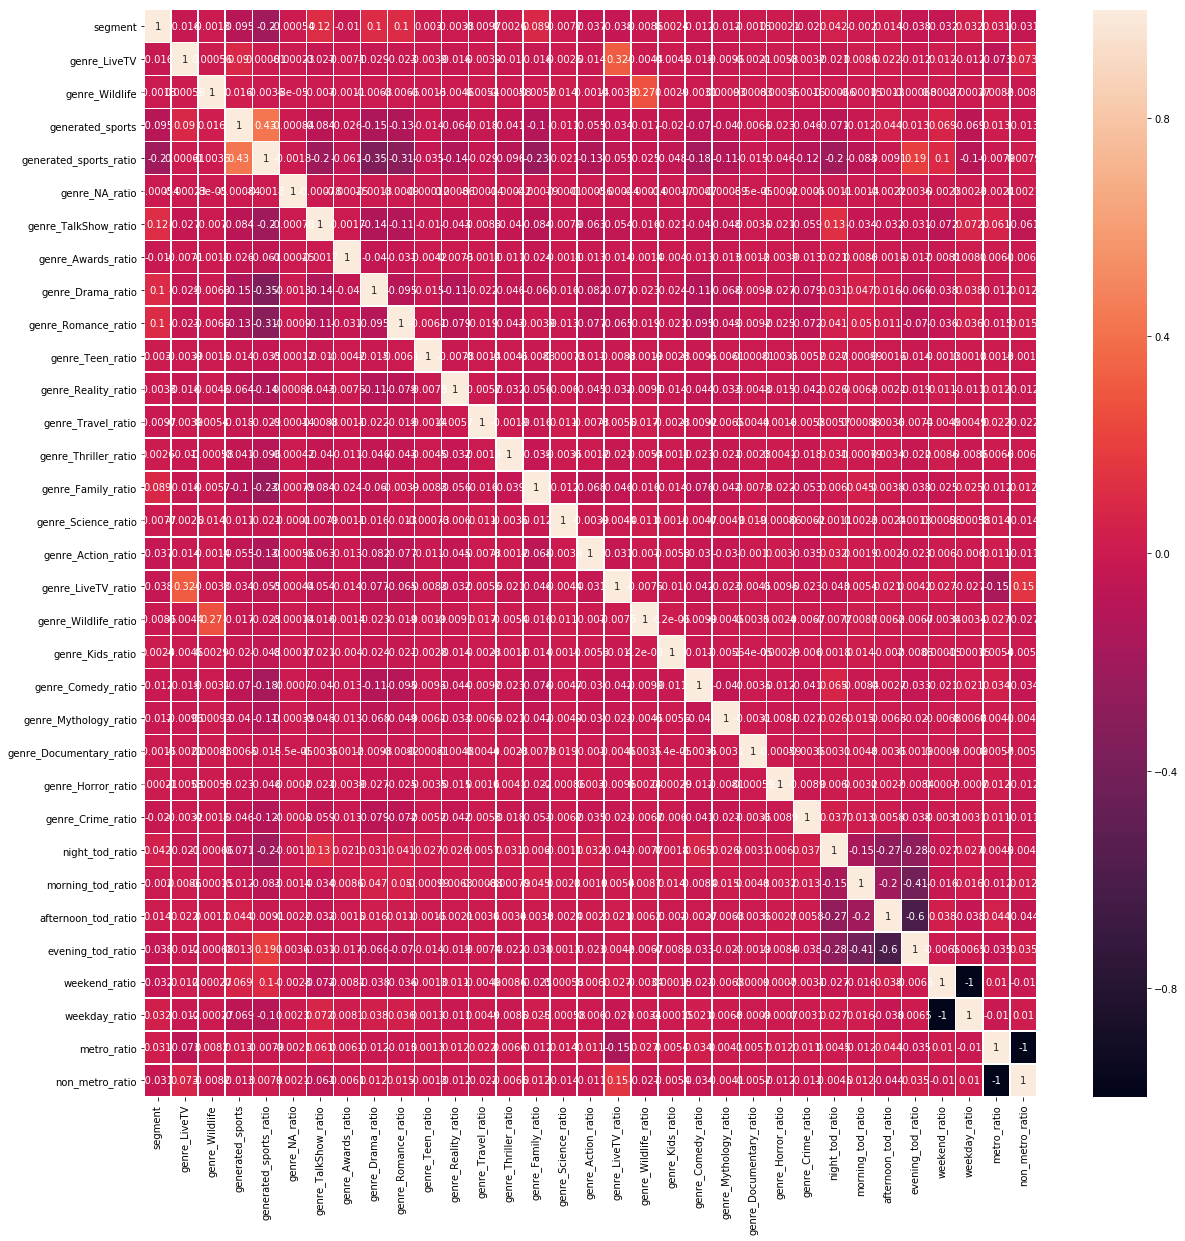

In [117]:
Var_Corr = df_new.corr()
# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True,linewidths=.5, ax=ax)

In [ ]:
import matplotlib.pyplot as plt
plt.show()

In [ ]:
# Plotting distribution of Segments:
#sns.countplot(y='metro_ratio', data=df_new)
#plt.ylabel('matro_ratio')
#plt.xlabel('Count')
#plt.title('Distribution of metros')
#plt.show()

In [ ]:
df_new.to_csv('intermidate_state.csv')

In [96]:
df_new[df_new.segment == 1].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
segment,15255.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
genre_LiveTV,15255.0,77.338315,1519.662122,0.0,0.000000,0.000000,0.000000,155208.000000
genre_Wildlife,15255.0,8.800656,382.275589,0.0,0.000000,0.000000,0.000000,43799.000000
generated_sports,15255.0,845.520485,4928.095744,0.0,0.000000,0.000000,0.000000,145748.000000
generated_sports_ratio,15255.0,0.054075,0.190283,0.0,0.000000,0.000000,0.000000,1.000000
genre_NA_ratio,15255.0,0.000001,0.000127,0.0,0.000000,0.000000,0.000000,0.015625
genre_TalkShow_ratio,15255.0,0.160619,0.321409,0.0,0.000000,0.000000,0.085810,1.000000
genre_Awards_ratio,15255.0,0.004353,0.047546,0.0,0.000000,0.000000,0.000000,1.000000
genre_Drama_ratio,15255.0,0.277114,0.352059,0.0,0.000000,0.064449,0.511739,1.000000
genre_Romance_ratio,15255.0,0.201991,0.308986,0.0,0.000000,0.004301,0.315629,1.000000


In [102]:
# df_new.to_csv('C:Desktop/intermidate_state.csv')

In [103]:
#30 Features 
df_new.shape

(200000, 33)

In [104]:
df_test_new.shape

(100000, 29)

In [105]:
df_test_new[df_new.segment == 1].describe().transpose()

C:\Users\anike\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,count,mean,std,min,25%,50%,75%,max
night_tod_ratio,7552.0,0.104841,0.223846,0.0,0.000000,0.000000,0.086322,1.000000
morning_tod_ratio,7552.0,0.138985,0.234613,0.0,0.000000,0.018586,0.181046,1.000000
afternoon_tod_ratio,7552.0,0.327197,0.318086,0.0,0.009734,0.254663,0.529071,1.000000
evening_tod_ratio,7552.0,0.428977,0.346156,0.0,0.103863,0.381930,0.713164,1.000000
generated_sports_ratio,7552.0,0.316528,0.399261,0.0,0.000000,0.019600,0.747262,0.999962
genre_NA_ratio,7552.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
genre_TalkShow_ratio,7552.0,0.090977,0.248763,0.0,0.000000,0.000000,0.001330,1.000000
genre_Awards_ratio,7552.0,0.008610,0.070979,0.0,0.000000,0.000000,0.000000,1.000000
genre_Drama_ratio,7552.0,0.166570,0.299556,0.0,0.000000,0.000000,0.193288,1.000000
genre_Romance_ratio,7552.0,0.109476,0.248401,0.0,0.000000,0.000000,0.036990,1.000000


In [106]:
df_new.columns

Index(['segment', 'genre_LiveTV', 'genre_Wildlife', 'generated_sports',
       'generated_sports_ratio', 'genre_NA_ratio', 'genre_TalkShow_ratio',
       'genre_Awards_ratio', 'genre_Drama_ratio', 'genre_Romance_ratio',
       'genre_Teen_ratio', 'genre_Reality_ratio', 'genre_Travel_ratio',
       'genre_Thriller_ratio', 'genre_Family_ratio', 'genre_Science_ratio',
       'genre_Action_ratio', 'genre_LiveTV_ratio', 'genre_Wildlife_ratio',
       'genre_Kids_ratio', 'genre_Comedy_ratio', 'genre_Mythology_ratio',
       'genre_Documentary_ratio', 'genre_Horror_ratio', 'genre_Crime_ratio',
       'night_tod_ratio', 'morning_tod_ratio', 'afternoon_tod_ratio',
       'evening_tod_ratio', 'weekend_ratio', 'weekday_ratio', 'metro_ratio',
       'non_metro_ratio'],
      dtype='object')

In [107]:
df_test_new.columns

Index(['night_tod_ratio', 'morning_tod_ratio', 'afternoon_tod_ratio',
       'evening_tod_ratio', 'generated_sports_ratio', 'genre_NA_ratio',
       'genre_TalkShow_ratio', 'genre_Awards_ratio', 'genre_Drama_ratio',
       'genre_Romance_ratio', 'genre_Teen_ratio', 'genre_Reality_ratio',
       'genre_Travel_ratio', 'genre_Thriller_ratio', 'genre_Family_ratio',
       'genre_Science_ratio', 'genre_Action_ratio', 'genre_LiveTV_ratio',
       'genre_Wildlife_ratio', 'genre_Kids_ratio', 'genre_Comedy_ratio',
       'genre_Mythology_ratio', 'genre_Documentary_ratio',
       'genre_Horror_ratio', 'genre_Crime_ratio', 'weekend_ratio',
       'weekday_ratio', 'metro_ratio', 'non_metro_ratio'],
      dtype='object')

In [348]:
df_test_new["segment"] = np.nan

In [349]:
df_test_new.to_csv('final_test_data.csv')

In [350]:
df_new.head()

,segment,generated_sports_ratio,genre_NA_ratio,genre_TalkShow_ratio,genre_Awards_ratio,genre_Drama_ratio,genre_Romance_ratio,genre_Teen_ratio,genre_Reality_ratio,genre_Travel_ratio,...,genre_Horror_ratio,genre_Crime_ratio,night_tod_ratio,morning_tod_ratio,afternoon_tod_ratio,evening_tod_ratio,weekend_ratio,weekday_ratio,metro_ratio,non_metro_ratio
0,0,0.976083,0.0,0.0,0.0,0.001688,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.090039,0.909961,0.018008,0.981992,1.000000,0.000000
1,0,0.000000,0.0,0.0,0.0,0.585255,0.198130,0.0,0.0,0.0,...,0.0,0.022729,0.300951,0.158450,0.237425,0.303175,0.485264,0.514736,0.322623,0.677377
2,0,0.194401,0.0,0.0,0.0,0.710014,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.301504,0.176453,0.522044,0.272758,0.727242,0.000000,1.000000
3,0,0.951249,0.0,0.0,0.0,0.029887,0.018863,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.029887,0.970113,0.000000,0.000000,1.000000,0.000000,1.000000
4,1,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000


In [351]:
y_new = df_new['segment']

In [352]:
X_new = df_new.drop('segment',1)

In [353]:
X_new.shape

(200000, 29)

In [354]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from imblearn.over_sampling import SMOTE


In [355]:
# smt = SMOTE()
# X_new,y_new = smt.fit_sample(X_new,y_new)


In [356]:
kmeans = KMeans(n_clusters=2)

In [357]:
df_new = df_new.fillna(df_new.mean())

In [358]:
kmeans.fit(df_new)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [359]:
kmeans.labels_

array([0, 1, 1, ..., 0, 1, 1])

In [360]:
len(kmeans.labels_)


200000

In [361]:
y_new = np.array(y_new)

In [362]:
mis_classified = np.where(kmeans.labels_!=y_new)
len(mis_classified)

1

In [363]:
len(mis_classified[0])

113319

In [364]:
mis_classified

(array([     1,      2,      3, ..., 199996, 199998, 199999], dtype=int64),)

In [365]:
error = 113319/20000

In [366]:
error

5.66595

In [367]:
accuracy = (200000-113319)/200000

In [368]:
accuracy

0.433405

In [369]:
df_new.head()

,segment,generated_sports_ratio,genre_NA_ratio,genre_TalkShow_ratio,genre_Awards_ratio,genre_Drama_ratio,genre_Romance_ratio,genre_Teen_ratio,genre_Reality_ratio,genre_Travel_ratio,...,genre_Horror_ratio,genre_Crime_ratio,night_tod_ratio,morning_tod_ratio,afternoon_tod_ratio,evening_tod_ratio,weekend_ratio,weekday_ratio,metro_ratio,non_metro_ratio
0,0,0.976083,0.0,0.0,0.0,0.001688,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.090039,0.909961,0.018008,0.981992,1.000000,0.000000
1,0,0.000000,0.0,0.0,0.0,0.585255,0.198130,0.0,0.0,0.0,...,0.0,0.022729,0.300951,0.158450,0.237425,0.303175,0.485264,0.514736,0.322623,0.677377
2,0,0.194401,0.0,0.0,0.0,0.710014,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.301504,0.176453,0.522044,0.272758,0.727242,0.000000,1.000000
3,0,0.951249,0.0,0.0,0.0,0.029887,0.018863,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.029887,0.970113,0.000000,0.000000,1.000000,0.000000,1.000000
4,1,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000


In [370]:
dff = pd.read_csv('final_test_data.csv')

In [371]:
dff.shape

(100000, 31)

In [372]:
X_test = dff.drop('segment',1)
X_test = X_test.fillna(X_test.mean())
Y_test = dff.segment

In [373]:
# smt = SMOTE()
# X_test,Y_test = smt.fit_sample(X_test,Y_test)

In [374]:
seg_pred = kmeans.predict(X_test)

In [375]:
dff.replace

<bound method DataFrame.replace of        Unnamed: 0  night_tod_ratio  morning_tod_ratio  afternoon_tod_ratio  \
0               0         0.110638           0.123371             0.148949   
1               1         0.000000           0.000000             0.752715   
2               2         0.000000           0.000000             0.700424   
3               3         0.000000           0.000000             1.000000   
4               4         0.003519           0.154404             0.685114   
5               5         0.000000           0.000000             0.195648   
6               6         0.216036           0.000000             0.111730   
7               7         0.000000           0.000000             1.000000   
8               8         0.000000           0.000000             0.259916   
9               9         0.000000           0.000000             0.378857   
10             10         0.000000           0.479592             0.000000   
11             11         0.0

In [376]:
dff['segment'] = seg_pred

In [377]:
dff.head()

,Unnamed: 0,night_tod_ratio,morning_tod_ratio,afternoon_tod_ratio,evening_tod_ratio,generated_sports_ratio,genre_NA_ratio,genre_TalkShow_ratio,genre_Awards_ratio,genre_Drama_ratio,...,genre_Comedy_ratio,genre_Mythology_ratio,genre_Documentary_ratio,genre_Horror_ratio,genre_Crime_ratio,weekend_ratio,weekday_ratio,metro_ratio,non_metro_ratio,segment
0,0,0.110638,0.123371,0.148949,0.617042,0.996648,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.482937,0.517063,0.00053,0.99947,1
1,1,0.000000,0.000000,0.752715,0.247285,0.000000,0.0,0.595262,0.0,0.000000,...,0.404738,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.00000,1.00000,1
2,2,0.000000,0.000000,0.700424,0.299576,0.923506,0.0,0.000000,0.0,0.000000,...,0.076494,0.0,0.0,0.0,0.000000,0.000000,1.000000,1.00000,0.00000,0
3,3,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,1.00000,0.00000,0
4,4,0.003519,0.154404,0.685114,0.156963,0.037641,0.0,0.533163,0.0,0.404351,...,0.000000,0.0,0.0,0.0,0.024845,0.014822,0.985178,0.00000,1.00000,1


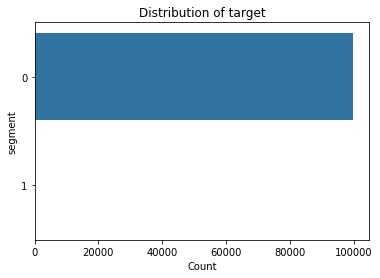

In [378]:
sns.countplot(y='segment', data=dff)
plt.ylabel('segment')
plt.xlabel('Count')
plt.title('Distribution of target')
plt.show()

In [379]:
dff['segment'].value_counts()

0    99971
1       29
Name: segment, dtype: int64

In [395]:
#NaiveBayes approacch
from sklearn.model_selection import train_test_split as tts
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [381]:
x=df_new.drop('segment',axis=1)
y=df_new['segment']
x_train1,x_test1,y_train1,y_test1=tts(x,y,test_size= 0.4,random_state=42)
nb=GaussianNB()
x_train1.fillna(x_train1.mean(),inplace=True)
x_test1.fillna(x_test1.mean(),inplace=True)
nb.fit(x_train1,y_train1)
y_pred=nb.predict(x_test1)   
accuracy_score(y_test1, y_pred, normalize = True)


C:\Users\anike\Anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


0.6941875

In [403]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsClassifier

In [404]:
X_new = pd.DataFrame(X_new)
X_new.head()

,generated_sports_ratio,genre_NA_ratio,genre_TalkShow_ratio,genre_Awards_ratio,genre_Drama_ratio,genre_Romance_ratio,genre_Teen_ratio,genre_Reality_ratio,genre_Travel_ratio,genre_Thriller_ratio,...,genre_Horror_ratio,genre_Crime_ratio,night_tod_ratio,morning_tod_ratio,afternoon_tod_ratio,evening_tod_ratio,weekend_ratio,weekday_ratio,metro_ratio,non_metro_ratio
0,0.976083,0.0,0.0,0.0,0.001688,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.090039,0.909961,0.018008,0.981992,1.000000,0.000000
1,0.000000,0.0,0.0,0.0,0.585255,0.198130,0.0,0.0,0.0,0.0,...,0.0,0.022729,0.300951,0.158450,0.237425,0.303175,0.485264,0.514736,0.322623,0.677377
2,0.194401,0.0,0.0,0.0,0.710014,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.301504,0.176453,0.522044,0.272758,0.727242,0.000000,1.000000
3,0.951249,0.0,0.0,0.0,0.029887,0.018863,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.029887,0.970113,0.000000,0.000000,1.000000,0.000000,1.000000
4,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000


NameError: name 'n_neighbors' is not defined

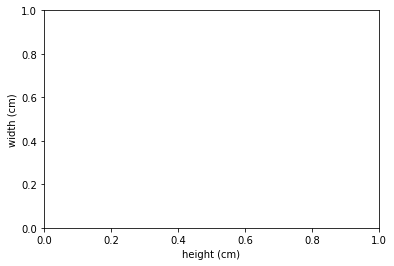

In [407]:
X_train, X_test, y_train, y_test = tts(X_new, y_new, random_state=0)
def plot_hotstar_knn(Xnew, ynew, n_neighbors, weights):
    X_mat = X[['generated_sports_ratio', 'weekend_ratio']].as_matrix()
    y_mat = y.as_matrix()
# Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF','#AFAFAF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#AFAFAF'])
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)
# Plot the decision boundary by assigning a color in the color map
    # to each mesh point.
    
    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50
    
    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size),
                         np.arange(y_min, y_max, mesh_step_size))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
# Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    patch0 = mpatches.Patch(color='#FF0000', label='apple')
    patch1 = mpatches.Patch(color='#00FF00', label='mandarin')
    patch2 = mpatches.Patch(color='#0000FF', label='orange')
    patch3 = mpatches.Patch(color='#AFAFAF', label='lemon')
    plt.legend(handles=[patch0, patch1, patch2, patch3])
plt.xlabel('height (cm)')
plt.ylabel('width (cm)')
plt.title("4-Class classification (k = %i, weights = '%s')"
           % (n_neighbors, weights))    
plt.show()
plot_hotstar_knn(X_train, y_train, 5, 'uniform')


In [408]:
df_new.head()

,segment,generated_sports_ratio,genre_NA_ratio,genre_TalkShow_ratio,genre_Awards_ratio,genre_Drama_ratio,genre_Romance_ratio,genre_Teen_ratio,genre_Reality_ratio,genre_Travel_ratio,...,genre_Horror_ratio,genre_Crime_ratio,night_tod_ratio,morning_tod_ratio,afternoon_tod_ratio,evening_tod_ratio,weekend_ratio,weekday_ratio,metro_ratio,non_metro_ratio
0,0,0.976083,0.0,0.0,0.0,0.001688,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.090039,0.909961,0.018008,0.981992,1.000000,0.000000
1,0,0.000000,0.0,0.0,0.0,0.585255,0.198130,0.0,0.0,0.0,...,0.0,0.022729,0.300951,0.158450,0.237425,0.303175,0.485264,0.514736,0.322623,0.677377
2,0,0.194401,0.0,0.0,0.0,0.710014,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.301504,0.176453,0.522044,0.272758,0.727242,0.000000,1.000000
3,0,0.951249,0.0,0.0,0.0,0.029887,0.018863,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.029887,0.970113,0.000000,0.000000,1.000000,0.000000,1.000000
4,1,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000


In [431]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.metrics import classification_report , accuracy_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
X_dt = df_new.drop('segment',1)
y_dt = df_new['segment']
dt = DecisionTreeClassifier(max_depth=6 ,criterion='gini' , random_state= 42)
x_train,x_test,y_train,y_test = tts(X_dt,y_dt,test_size = 0.3 ,random_state = 42,stratify = y)
dt.fit(x_train,y_train)
y_pred = dt.predict(x_test)
dt.score(x_test,y_test)
acc = accuracy_score(y_test,y_pred)
acc



0.92345

In [419]:
print(dt.get_params())

{'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 42, 'splitter': 'best'}


In [420]:
params = {'max_depth':np.arange(2,10),'min_samples_leaf' : np.arange(0.05,0.2,0.01),'max_features':np.arange(0.2,0.8,1.0)}

In [424]:
grid_dt = GridSearchCV(estimator=dt,param_grid=params,cv =10,n_jobs= -1,scoring='accuracy')

In [425]:
grid_dt.fit(X_dt,y_dt)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]), 'min_samples_leaf': array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15,
       0.16, 0.17, 0.18, 0.19, 0.2 ]), 'max_features': array([0.2])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [432]:
best = grid_dt.best_params_

In [428]:
best

{'max_depth': 2, 'max_features': 0.2, 'min_samples_leaf': 0.05}

In [429]:
grid_dt.best_score_

0.923725

In [416]:
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     55424
           1       0.00      0.00      0.00      4576

   micro avg       0.92      0.92      0.92     60000
   macro avg       0.46      0.50      0.48     60000
weighted avg       0.85      0.92      0.89     60000



In [436]:

roc_auc_score(y_test,y_pred)

0.4998466368360277

In [430]:
tree.export_graphviz(dt,out_file='tree.dot')  

In [437]:
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = StringIO()
# export_graphviz(dt, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())